In [1]:
# ===== 1. IMPORTS OCH INLÄSNING =====
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix


# ===== GLOBAL PROJEKTDATA =====
# Syfte: En central dictionary för att lagra projektets data och parametrar
# Alternativ: Globala variabler, konfigurationsfil, eller klasstruktur
# Varför: Dictionary ger flexibel struktur och enkel åtkomst till data

# ----- Datalagring -----
# Vad: Tom dictionary som fylls under projektets gång
# Varför: Möjliggör dynamisk lagring av data mellan olika analysdelar
# Parametrar: Kommer innehålla nyckel-värde par för viktiga projektvariabler
PROJECT_DATA = {}

# ===== DATAINLÄSNING =====


# ----- Inläsning -----
# Läser in data från CSV-fil till pandas DataFrame
df = pd.read_csv('project_data.csv')

# ----- Arbetskopia -----
# Vad: Skapar en kopia av data för säker bearbetning
# Varför: Undviker att modifiera originaldata av misstag
# Parametrar: Ingen parametermodifiering, ren kopia
df_clean = df.copy()

# Ta bort onödig indexkolumn
df_clean = df_clean.drop('Unnamed: 0', axis=1)

# ===== 2. INITIAL DATAINSPEKTION =====
# Syfte: Undersöka datasetets grundläggande egenskaper och kvalitet
# Alternativ: Mer detaljerad EDA, visualiseringar, beskrivande statistik
# Varför: Snabb överblick för att identifiera omfattning och datakvalitetsproblem

# ----- Dimensioner -----
# Vad: Visar antal rader och kolumner i datasetet
# Varför: Ger snabb överblick av datasetets storlek
print("Initial datainspektion:")
print(f"Datasetets dimensioner: {df_clean.shape}")

# ----- Saknade värden -----
# Vad: Identifierar kolumner med saknade värden
# Varför: Kritiskt att känna till för vidare databehandling
# Parametrar: Visar endast kolumner där antalet saknade värden > 0
print("\nSaknade värden per kolumn:")
print(df_clean.isnull().sum()[df_clean.isnull().sum() > 0])

# ===== 3. HANTERA SAKNADE VÄRDEN =====
# Syfte: Ta bort rader med saknade värden i Revenue-kolumnen först
# Alternativ: Imputering av saknade värden eller behålla rader med saknade värden
# Varför: Revenue är målvariabeln och kan inte imputeras meningsfullt

# ----- Revenue-rensning -----
# Vad: Tar bort rader där Revenue saknas
# Varför: Målvariabeln måste finnas för träning/utvärdering
# Parametrar: dropna() med subset=['Revenue'] tar endast bort rader där Revenue saknas
print("\nHantering av saknade värden:")
print(f"Rader före Revenue-rensning: {len(df_clean)}")
df_clean = df_clean.dropna(subset=['Revenue'])
print(f"Rader efter Revenue-rensning: {len(df_clean)}")

# ===== Data Cleaning: Weekend Column =====
# Syfte: Hantera felaktiga ('Name:Zara') och saknade värden (np.nan) i Weekend-kolumnen
# 
# RESONEMANG FÖR VALD LÖSNING:
# 1. Databevarande:
#    - Vill behålla så mycket data som möjligt 
#    - Att ta bort rader med saknade värden skulle riskera bias
#
# 2. 'Missing' som informativ feature:
#    - Saknad Weekend-data kan vara ett mönster i sig
#    - Modellen kan lära sig från sessioner med 'Missing'
#    - Mer informativt än att gissa/imputera värden
#
# 3. Alternativ som övervägdes:
#    - Imputation med mode/median (förkastat: skulle skapa bias)
#    - Radera rader (förkastat: för stor dataförlust)
#    - Separata kategorier för 'Name:Zara' och np.nan (förkastat: onödig komplexitet)
#
# 4. Transparens:
#    - 'Missing' gör det tydligt att data saknas
#    - Bättre än att dölja osäkerhet genom imputation

# Skapa indikator för felaktiga/saknade värden
df_clean['Weekend_missing'] = df_clean['Weekend'].isin(['Name:Zara', np.nan])

# Standardisera värdena i Weekend-kolumnen
df_clean['Weekend'] = df_clean['Weekend'].replace({
    'Name:Zara': 'Missing', 
    'True': True, 
    'False': False, 
    np.nan: 'Missing'
})

# ===== SPECIALDAY HANTERING =====
# Syfte: Hantera saknade värden i SpecialDay-kolumnen och skapa en indikator för saknade värden
# Alternativ: 
#   - Ta bort rader med saknade värden (förkastat: för stor dataförlust)
#   - Imputera med medelvärde (förkastat: special days är binära/kategoriska)
#   - Imputera med median (förkastat: samma problem som medelvärde)
# Varför: Behålla all data genom att markera saknade värden och ge dem ett neutralt värde

# ----- Indikatorvariabel -----
# Vad: Skapar en boolean-kolumn som markerar saknade värden
# Varför: Bevara information om att värdet saknades ursprungligen
# Parametrar: isnull() returnerar True för saknade värden
df_clean['SpecialDay_missing'] = df_clean['SpecialDay'].isnull()

# ----- Värdeimputering -----
# Vad: Ersätter saknade värden med 0
# Varför: 0 indikerar "ingen speciell dag" vilket är det mest neutrala antagandet
# Parametrar: fillna(0) ersätter alla NaN-värden med 0
df_clean['SpecialDay'] = df_clean['SpecialDay'].fillna(0)

# ===== BROWSER OCH REGION HANTERING =====
# Syfte: Hantera saknade värden i Browser- och Region-kolumnerna för att maximera 
#        datakvaliteten utan att förlora information
# Alternativ:
#   - Ta bort rader med saknade värden (förkastat: dataförlust på ~5% av raderna)
#   - Imputera med mode/median (förkastat: skulle dölja verkliga mönster)
#   - Skapa dummy-variabler (förkastat: onödig dimensionalitet)
#   - Gruppera saknade värden (vald: bevarar information och mönster)
# Varför: 
#   - Behåller all data och markerar tydligt var värden saknas
#   - Möjliggör för modellen att hitta mönster i saknade värden
#   - Konsekvent hantering av kategoriska variabler

# ----- Browser-hantering -----
# Vad: Skapar två features från Browser-kolumnen:
#      1. Indikator för saknade värden (True/False)
#      2. Kategorisk kolumn där saknade värden = 'Missing'
# Varför: Ger modellen möjlighet att lära sig från både närvaro och 
#         frånvaro av browser-information
# Parametrar: 
#   - isnull(): identifierar saknade värden
#   - 'Missing': tydlig markör som skiljer sig från vanliga browser-värden
df_clean['Browser_missing'] = df_clean['Browser'].isnull()
df_clean['Browser'] = df_clean['Browser'].fillna('Missing')

# ----- Region-hantering -----
# Vad: Identisk approach som Browser-hanteringen för konsistens
# Varför: 
#   - Samma logik gäller för geografisk data
#   - Konsekvent datahantering underlättar tolkning
# Parametrar:
#   - isnull(): samma logik som för Browser
#   - 'Missing': konsekvent markör genom hela datasetet
df_clean['Region_missing'] = df_clean['Region'].isnull()
df_clean['Region'] = df_clean['Region'].fillna('Missing')

# ----- Månadsnamnskorrigeringar -----
# Vad: Standardiserar månadsnamn till konsekvent tre-bokstavsformat
# Varför: Säkerställer enhetlig formatering och korrigerar felstavningar

# Korrigera 'Sept' till 'Sep' (vanlig felstavning)
df_clean.loc[df_clean['Month'] == 'Sept', 'Month'] = 'Sep'

# Korrigera 'Turc' till 'Jan'
# Resonemang:
# 1. I det ursprungliga datasetet saknas endast januari ('Jan')
# 2. I vår skolversion saknas både 'Jan' och 'Apr'
# 3. Eftersom 'Turc' är ett uppenbart felaktigt månadsnamn och
#    vi vet att januari saknas i originaldatan, drar vi slutsatsen
#    att 'Turc' måste vara 'Jan'
df_clean.loc[df_clean['Month'] == 'Turc', 'Month'] = 'Jan'

# Korrigera 'June' till 'Jun' för konsekvent tre-bokstavsformat
df_clean.loc[df_clean['Month'] == 'June', 'Month'] = 'Jun'

# ===== 5. HANTERA DURATION-VÄRDEN =====
# Syfte: Identifiera och hantera orimligt långa sessionsvaraktigheter för olika typer av sidbesök
# Alternativ:
#   - Ingen begränsning (förkastat: extremvärden kan störa modellen)
#   - Percentilbaserade gränser (förkastat: mindre intuitivt)
#   - Medelvärde + standardavvikelser (förkastat: känsligt för outliers)
#   - Fasta tidsgränser (vald: enkel att förstå och motivera)
# Varför:
#   - Extrema duration-värden kan indikera tekniska fel eller inaktiva sessioner
#   - Behöver balansera mellan att behålla äkta data och filtrera bort orealistiska värden
#   - Vill bevara information om extremvärden via flaggor för framtida analys

# ----- Definiera tidsgränser -----
# Vad: Sätter maxgränser för olika typer av sidbesök baserat på användarlogik
# Varför: 
#   - Olika aktiviteter har naturligt olika tidsspann
#   - Fasta gränser gör det enkelt att kommunicera och justera vid behov
# Parametrar:
#   - admin_limit: 30 min - typisk tid för kontohantering/administrativa ärenden
#   - prod_limit: 4h - produktbrowsing kan inkludera research/jämförelser
#   - info_limit: 30 min - informationssökning är oftast mer fokuserad
admin_limit = 30 * 60  # 30 minuter i sekunder
prod_limit = 240 * 60  # 4 timmar i sekunder
info_limit = 30 * 60   # 30 minuter i sekunder

# ----- Hantera administrativa besök -----
# Vad: Flaggar och begränsar extrema administrativa sessioner
# Varför: Administrativa ärenden tar sällan mer än 30 minuter
# Parametrar: admin_limit (30 min) baserat på typiska kontoärenden
df_clean['Administrative_Duration_extreme'] = df_clean['Administrative_Duration'] > admin_limit
df_clean['Administrative_Duration'] = df_clean['Administrative_Duration'].clip(upper=admin_limit)

# ----- Hantera produktrelaterade besök -----
# Vad: Flaggar och begränsar extrema produktbrowsing-sessioner
# Varför: Även omfattande produktjämförelser bör rimligen avslutas inom 4h
# Parametrar: prod_limit (4h) tillåter grundlig research men filtrerar bort inaktiva sessioner
df_clean['ProductRelated_Duration_extreme'] = df_clean['ProductRelated_Duration'] > prod_limit
df_clean['ProductRelated_Duration'] = df_clean['ProductRelated_Duration'].clip(upper=prod_limit)

# ----- Hantera informationssökningar -----
# Vad: Flaggar och begränsar extrema informationssökningssessioner
# Varför: Informationssökning är typiskt mer målinriktad än produktbrowsing
# Parametrar: info_limit (30 min) baserat på normal tid för att hitta specifik information
df_clean['Informational_Duration_extreme'] = df_clean['Informational_Duration'] > info_limit
df_clean['Informational_Duration'] = df_clean['Informational_Duration'].clip(upper=info_limit)

# ===== 6. HANTERA NEGATIVA ADMINISTRATIVE VÄRDEN =====
# Syfte: Identifiera och korrigera negativa värden i Administrative-kolumnen
# Alternativ:
#   - Ta bort rader med negativa värden (förkastat: förlorar potentiellt värdefull data)
#   - Ersätta med medelvärde (förkastat: kan skapa bias)
#   - Sätta till 0 (vald: bevarar övrig information i raden)
# Varför:
#   - Negativa besöksantal är tekniskt omöjliga
#   - Vill bevara information om att värdet var felaktigt via flagga
#   - Minimalt ingrepp som inte påverkar övriga variabler

# ----- Flagga negativa värden -----
# Vad: Skapar en binär indikator för negativa Administrative-värden
# Varför: Bevarar information om datakvalitetsproblem för senare analys
# Parametrar: Ingen tröskel behövs - alla negativa värden är per definition felaktiga
df_clean['Administrative_was_negative'] = df_clean['Administrative'] < 0

# ----- Korrigera negativa värden -----
# Vad: Ersätter alla negativa värden med 0
# Varför: 0 är det minsta möjliga antalet besök och en naturlig undre gräns
# Parametrar: lower=0 eftersom negativa besöksantal är omöjliga
df_clean['Administrative'] = df_clean['Administrative'].clip(lower=0)

# ===== 7. HANTERA BOUNCE RATES =====
# Syfte: Normalisera bounce rates till ett rimligt intervall och flagga extremvärden
# Alternativ:
#   - Ta bort extremvärden (förkastat: förlorar information)
#   - Ersätta med medelvärde (förkastat: kan skapa bias)
#   - Normalisera till rimligt intervall (vald: bevarar relativa förhållanden)
# Varför:
#   - Bounce rates bör logiskt vara positiva
#   - Originaldata innehåller orimliga värden (negativa och >100%)
#   - Normalisering bevarar relativa mönster medan extrema värden flaggas

# ----- Identifiera extremvärden -----
# Vad: Markerar värden utanför intervallet som används i originaldatasetet
# Varför: Bevarar information om datakvalitetsproblem för senare analys
# Parametrar: 
#   - Undre gräns: 0 (negativa bounce rates är tekniskt omöjliga)
#   - Övre gräns: 0.2 (baserat på gränsvärdet i originaldatasetet)
extremes = (df_clean['BounceRates'] < 0) | (df_clean['BounceRates'] > 0.2)

# ----- Normalisera värden -----
# Vad: Omvandlar alla värden till intervallet [0,0.2]
# Varför: Matchar skalan som används i originaldatasetet
# Parametrar:
#   - bounce_range: 2.598 (ursprunglig dataspridning från -0.499 till 2.099)
#   - Målintervall: [0,0.2] (för att matcha originaldatasetets gränsvärde)
bounce_range = 2.099 + 0.499  # Från originaldata: max - (-min)
normalized = (df_clean['BounceRates'] + 0.499) * 0.2 / bounce_range

print("BounceRates före normalisering:")
print(f"Min: {df_clean['BounceRates'].min():.3f}")
print(f"Max: {df_clean['BounceRates'].max():.3f}")

# ----- Uppdatera dataset -----
# Vad: Sparar både normaliserade värden och extremvärdsflaggor
# Varför: Möjliggör senare analys av både normaliserad data och kvalitetsproblem
df_clean['BounceRates_extreme'] = extremes
df_clean['BounceRates'] = normalized

print("\nBounceRates efter normalisering:")
print(f"Min: {df_clean['BounceRates'].min():.3f}")
print(f"Max: {df_clean['BounceRates'].max():.3f}")

# ===== 8. HANTERA PAGE VALUES =====
# Syfte: Identifiera och markera extrema PageValues för att möjliggöra särskild hantering
# Alternativ:
#   - Ta bort extremvärden (förkastat: förlorar potentiellt viktig information)
#   - Normalisera/transformera (förkastat: kan dölja viktiga mönster)
#   - Markera för separat analys (vald: bevarar data men möjliggör särbehandling)
# Varför:
#   - PageValues kan innehålla legitima extremvärden från högt värderade sidor
#   - Extremvärden kan vara viktiga signaler för konvertering
#   - Markering möjliggör både inkludering och särskild hantering i analyser

# ----- Identifiera extremvärden -----
# Vad: Beräknar 99:e percentilen som gränsvärde för extrema PageValues
# Varför: 99:e percentilen är en etablerad statistisk gräns för outliers
# Parametrar: 
#   - Percentil: 0.99 (fångar det övre 1% av värdena som extrema)
page_value_limit = df_clean['PageValues'].quantile(0.99)

# ----- Markera extremvärden -----
# Vad: Skapar en boolean-kolumn som markerar extrema PageValues
# Varför: Möjliggör filtrering och särskild analys av dessa värden
df_clean['PageValues_extreme'] = df_clean['PageValues'] > page_value_limit

# ===== 9. VERIFIKATION =====
# Syfte: Genomför omfattande kvalitetskontroll av det bearbetade datasetet

# Varför:
#   - Säkerställer att datarengöringen gett önskat resultat
#   - Identifierar eventuella kvarstående problem
#   - Dokumenterar datasetets slutliga tillstånd

# ----- Grundläggande struktur -----
# Vad: Kontrollerar datasetets dimensioner
# Varför: Verifierar att antal rader och kolumner är rimligt
print("\nVERIFIKATION:")
print(f"Datasetets struktur: {df_clean.shape}")

# ----- Saknade värden -----

print("\nSaknade värden:")
missing_values = df_clean.isnull().sum()
print(missing_values[missing_values > 0] if any(missing_values > 0) else "Inga saknade värden")

# ----- Kategoriska variabler -----
print("\nUnika värden i kategoriska variabler:")
categorical_cols = ['Month', 'VisitorType', 'Weekend', 'Revenue']
for col in categorical_cols:
    print(f"\n{col}:")
    print(df_clean[col].value_counts())

# ----- Numeriska gränser -----
# Vad: Granskar statistiska mått för numeriska variabler
# Varför: Verifierar att värden ligger inom rimliga intervall
# Parametrar:
#   - Mått: Min, Max, Medelvärde
#   - Kontrollerade kolumner: Alla numeriska variabler
print("\nStatistik för numeriska variabler:")
numeric_cols = ['Administrative', 'Administrative_Duration', 
                'Informational', 'Informational_Duration',
                'ProductRelated', 'ProductRelated_Duration',
                'BounceRates', 'ExitRates', 'PageValues']

for col in numeric_cols:
    print(f"\n{col}:")
    print(f"Min: {df_clean[col].min():.3f}")
    print(f"Max: {df_clean[col].max():.3f}")
    print(f"Mean: {df_clean[col].mean():.3f}")

# ----- Negativa värden -----
# Vad: Identifierar förekomst av negativa värden
# Varför: Vissa variabler bör inte kunna vara negativa
print("\nKontroll av negativa värden:")
for col in numeric_cols:
    neg_count = (df_clean[col] < 0).sum()
    if neg_count > 0:
        print(f"{col}: {neg_count} negativa värden")

# ----- Markerade problem -----
# Vad: Analyserar flaggade problemvärden
# Varför: Ger överblick över identifierade datakvalitetsproblem
print("\nMarkerade kolumner för saknade värden och extremvärden:")
marked_cols = [col for col in df_clean.columns if 'missing' in col.lower() or 'extreme' in col.lower()]
for col in marked_cols:
    print(f"\n{col}:")
    print(df_clean[col].value_counts())

# ----- Datasetjämförelse -----
# Vad: Jämför original och slutligt dataset
# Varför: Kvantifierar effekten av datarengöringen
print("\nJämförelse av dimensioner:")
print(f"Original dataset: {df.shape}")
print(f"Slutligt dataset: {df_clean.shape}")
print(f"Filtrerade rader: {len(df) - len(df_clean)}")

# ===== 10. TRAIN/TEST SPLIT =====
# Syfte: Dela upp data i tränings- och testset för modellvalidering
# Alternativ: 
#   - Endast träningsset (risk för överanpassning)
#   - K-fold cross validation (mer tidskrävande)
#   - Holdout validation (enklare men mindre robust)
# Varför: Train/test split ger bra balans mellan:
#   - Tillförlitlig validering
#   - Effektiv resursanvändning
#   - Enkel implementering

# ----- Datauppdelning -----
# Vad: Separerar features (X) och target (y)
# Varför: Krävs för supervised learning
X = df_clean.drop('Revenue', axis=1)
y = df_clean['Revenue']

# ----- Train/Test Split -----
# Vad: Delar data i tränings- och testset
# Varför: Möjliggör utvärdering på osedd data
# Parametrar:
#   - test_size=0.2: 20% för test, 80% för träning
#   - random_state=42: Reproducerbarhet
#   - stratify=y: Bevarar klassfördelningen
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42,
    stratify=y
)

# ----- Datapersistens -----
# Vad: Sparar all relevant data i PROJECT_DATA
# Varför: Centraliserad datahantering för senare användning
PROJECT_DATA['data'] = {
    'original': df,
    'cleaned': df_clean,
    'train_test': {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'original_columns': X.columns
    },
    'cleaning_info': {
        'missing_indicators': {
            'Browser': -1,
            'Region': -1,
            'SpecialDay': 0,
            'Weekend': 'Missing'
        },
        'categorical_columns': categorical_cols,
        'numeric_columns': numeric_cols
    }
}

# ----- Resultatanalys -----
# Vad: Visualiserar fördelningen av data
# Varför: Verifierar korrekt uppdelning
print("\nTrain/Test split genomförd:")
print(f"Training set: {X_train.shape[0]} rader ({X_train.shape[0]/len(df_clean)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]} rader ({X_test.shape[0]/len(df_clean)*100:.1f}%)")

print("\nKlassfördelning:")
print("Training set:")
print(pd.DataFrame({
    'Antal': y_train.value_counts(),
    'Procent': y_train.value_counts(normalize=True).round(3) * 100
}))
print("\nTest set:")
print(pd.DataFrame({
    'Antal': y_test.value_counts(),
    'Procent': y_test.value_counts(normalize=True).round(3) * 100
}))

# ----- Projektöversikt -----
# Vad: Hjälpfunktion för att visa projektets struktur
# Varför: Underlättar debugging och översikt
def show_project_status():
    print("\nPROJECT_DATA innehåller:")
    for key in PROJECT_DATA:
        print(f"\n{key}:")
        if isinstance(PROJECT_DATA[key], dict):
            for subkey in PROJECT_DATA[key]:
                print(f"  - {subkey}")

# Visa projektets status
show_project_status()

Initial datainspektion:
Datasetets dimensioner: (12330, 18)

Saknade värden per kolumn:
SpecialDay    123
Browser       184
Region        246
Revenue       147
dtype: int64

Hantering av saknade värden:
Rader före Revenue-rensning: 12330
Rader efter Revenue-rensning: 12183
BounceRates före normalisering:
Min: -0.499
Max: 2.099

BounceRates efter normalisering:
Min: 0.000
Max: 0.200

VERIFIKATION:
Datasetets struktur: (12183, 28)

Saknade värden:
Inga saknade värden

Unika värden i kategoriska variabler:

Month:
Month
May    3155
Nov    2962
Mar    1886
Dec    1708
Oct     545
Sep     440
Aug     427
Jul     426
Jun     285
Feb     181
Jan     168
Name: count, dtype: int64

VisitorType:
VisitorType
Returning_Visitor    10424
New_Visitor           1675
Other                   84
Name: count, dtype: int64

Weekend:
Weekend
False      9166
True       2833
Missing     184
Name: count, dtype: int64

Revenue:
Revenue
False    10303
True      1880
Name: count, dtype: int64

Statistik för numer

===== KAPITEL 2: EXPLORATORY DATA ANALYSIS =====

Analyserar training data: 9746 rader, 28 kolumner

===== 1. GRUNDLÄGGANDE STATISTIK =====

Numerisk statistik:
       Administrative  Administrative_Duration  Informational  \
count     9746.000000              9746.000000    9746.000000   
mean         2.311410                83.940401       0.510876   
std          3.337365               184.732507       1.286682   
min          0.000000                 0.000000       0.000000   
25%          0.000000                 0.000000       0.000000   
50%          1.000000                 8.000000       0.000000   
75%          4.000000                95.575000       0.000000   
max         26.000000              1800.000000      24.000000   

       Informational_Duration  ProductRelated  ProductRelated_Duration  \
count             9746.000000     9746.000000              9746.000000   
mean                35.029483       31.400267              1173.448888   
std                140.613709  

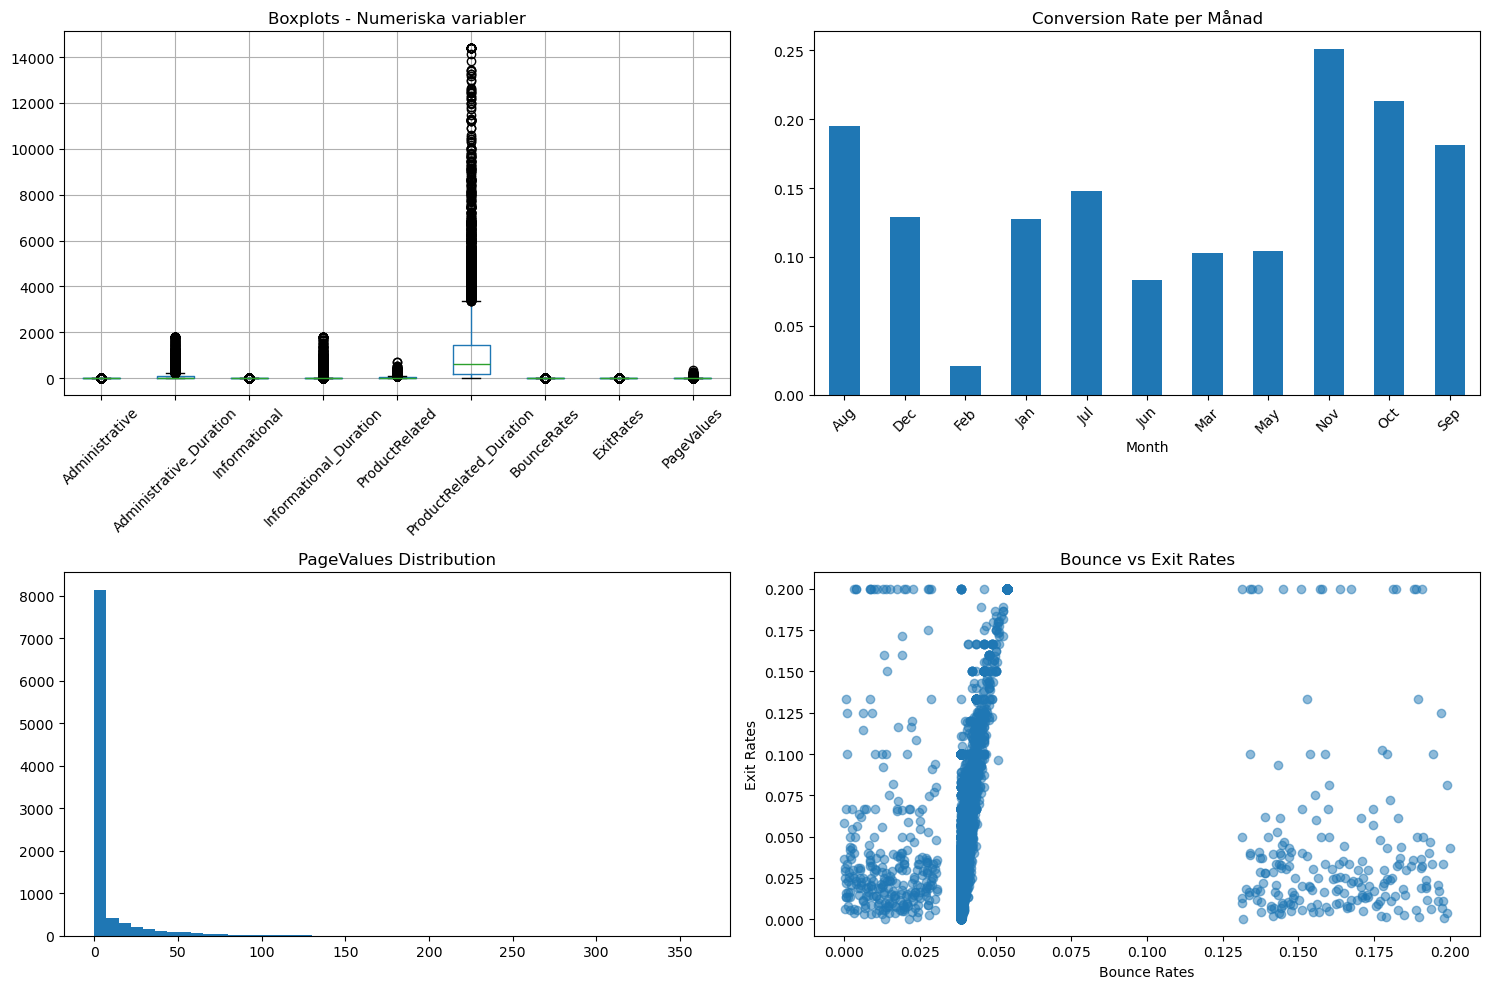


===== 3. KORRELATIONSANALYS =====

Korrelationer med Revenue:
Revenue                    1.000000
PageValues                 0.497604
ProductRelated_Duration    0.168171
ProductRelated             0.163411
Administrative             0.140655
Informational              0.107208
Administrative_Duration    0.086880
Informational_Duration     0.073316
BounceRates               -0.023120
ExitRates                 -0.206397
Name: Revenue, dtype: float64


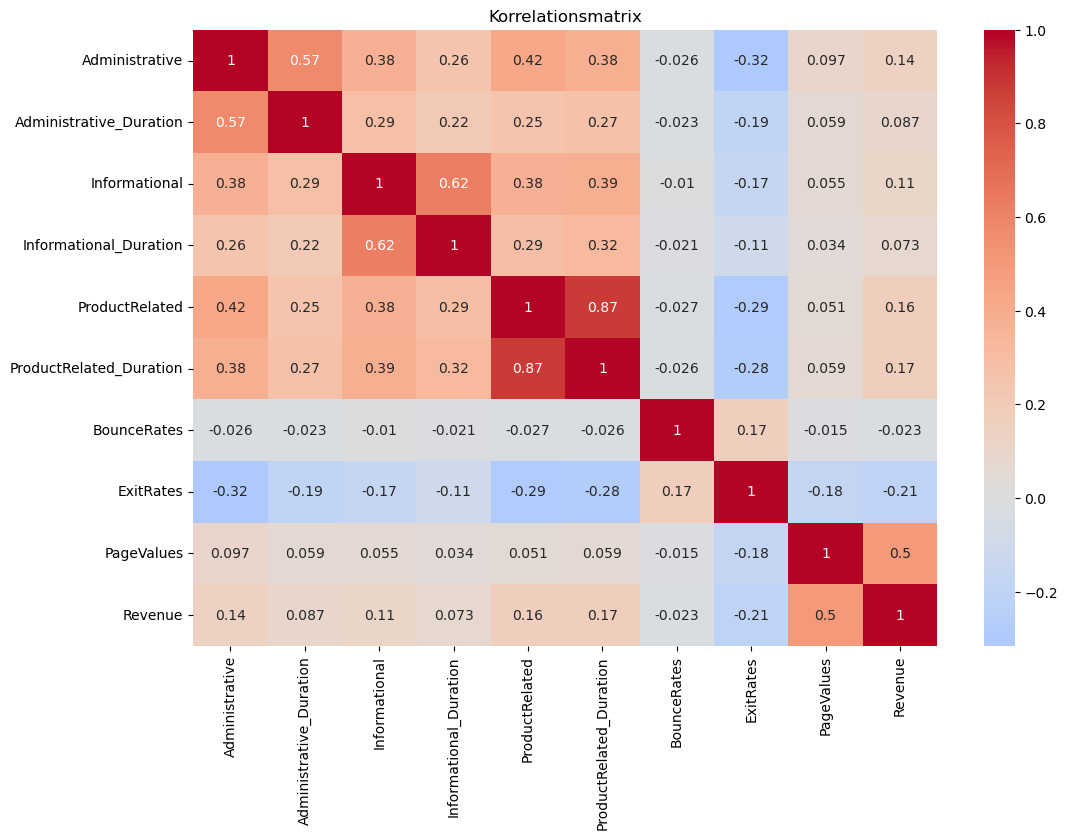


===== 4. SEGMENTANALYS =====

Konvertering baserat på antal produktsidor:
                      count      mean
ProductPages_Segment                 
Få                     2508  0.049841
Medium                 2462  0.134444
Många                  2346  0.197357
Väldigt många          2430  0.240741

Konvertering baserat på PageValues:
                   count      mean
PageValue_Segment                 
Inga                7593   0.03872
Låga                 745       0.4
Medel               1083  0.599261
Höga                 325  0.809231

PROJECT_DATA innehåller:

data:
  - original
  - cleaned
  - train_test
  - cleaning_info

eda:
  - correlations
  - monthly_conversion
  - product_page_segments
  - pagevalue_segments


C:\Users\joel\AppData\Local\Temp\ipykernel_23036\2135715568.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_conversion = df_train.groupby('ProductPages_Segment')['Revenue'].agg(['count', 'mean'])
C:\Users\joel\AppData\Local\Temp\ipykernel_23036\2135715568.py:185: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pagevalue_conversion = df_train.groupby('PageValue_Segment')['Revenue'].agg(['count', 'mean'])


In [2]:
# ===== KAPITEL 2: EXPLORATORY DATA ANALYSIS =====
# Syfte: Förbereda och analysera träningsdata för att förstå underliggande mönster och samband
# Alternativ: 
#   - Analysera hela datasetet (både träning och test)
#   - Analysera endast testdata
#   - Analysera subsets av data
# Varför: Vi analyserar endast träningsdata för att:
#   1. Undvika data leakage från testdata
#   2. Säkerställa att våra insikter kommer från samma data som modellen tränas på
#   3. Följa best practices inom ML där testdata ska vara helt separat

# ----- Dataförberedelse -----
# Vad: Skapar en analysversion av träningsdata med både features och target
# Varför: Behöver en samlad dataframe för att kunna analysera samband mellan features och target
# Parametrar:
#   - X_train: Features från träningsdata (från PROJECT_DATA)
#   - y_train: Target-variabel (Revenue)
#   - df_train: Ny dataframe som kombinerar features och target
print("===== KAPITEL 2: EXPLORATORY DATA ANALYSIS =====")

X_train = PROJECT_DATA['data']['train_test']['X_train']
y_train = PROJECT_DATA['data']['train_test']['y_train']
df_train = X_train.copy()
df_train['Revenue'] = y_train

print(f"\nAnalyserar training data: {df_train.shape[0]} rader, {df_train.shape[1]} kolumner")

# ===== GRUNDLÄGGANDE STATISTISK ANALYS =====
# Syfte: Beräkna och visa beskrivande statistik för både numeriska och kategoriska variabler


# ----- Numerisk Statistik -----
# Vad: Beräknar grundläggande statistiska mått för numeriska variabler
# Varför: Ger insikt i variablernas fördelning och spridning
# Parametrar:
#   - numeric_cols: Lista med numeriska kolumner från cleaning_info
#   - describe(): Ger count, mean, std, min, 25%, 50%, 75%, max
print("\n===== 1. GRUNDLÄGGANDE STATISTIK =====")
numeric_cols = PROJECT_DATA['data']['cleaning_info']['numeric_columns']
print("\nNumerisk statistik:")
print(df_train[numeric_cols].describe())

# ----- Kategorisk Analys -----
# Vad: Beräknar procentuell fördelning för kategoriska variabler
# Varför: Identifierar dominanta kategorier och obalanserad data
# Parametrar:
#   - categorical_cols: Lista med kategoriska kolumner från cleaning_info
#   - normalize=True: Konverterar counts till proportioner
#   - round(3): Avrundar till 3 decimaler
#   - * 100: Konverterar till procentform
print("\nKategorisk fördelning:")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df_train[col].value_counts(normalize=True).round(3) * 100)

# ===== VISUALISERINGAR =====
# Syfte: Skapa en översiktlig visualisering av nyckelvariabler i datasetet
# Alternativ: 
#   - Separata plottar (fördelar: mer detaljerade, nackdelar: svårare att jämföra)
#   - Interaktiva visualiseringar (fördelar: mer dynamiska, nackdelar: kräver mer kod)
#   - Andra plottningsbibliotek som Seaborn (fördelar: snyggare default-stil)
# Varför: Subplot-layout ger en bra överblick och möjliggör enkel jämförelse mellan olika aspekter

# ----- Layout & Storlek -----
# Vad: Skapar en 2x2 grid för fyra plottar
# Varför: Balanserad layout som ger tillräckligt utrymme för varje visualization
# Parametrar:
#   - figsize=(15, 10): Optimerad storlek för läsbarhet på vanliga skärmar
print("\n===== 2. VISUALISERINGAR =====")
plt.figure(figsize=(15, 10))

# ----- Numerisk Distribution -----
# Vad: Boxplots för alla numeriska variabler
# Varför: Visar fördelning, outliers och centralmått på ett kompakt sätt
# Parametrar:
#   - rotation=45: Förbättrar läsbarhet av långa variabelnamn
plt.subplot(2, 2, 1)
df_train[numeric_cols].boxplot()
plt.xticks(rotation=45)
plt.title('Boxplots - Numeriska variabler')

# ----- Säsongsanalys -----
# Vad: Visualiserar konverteringsgrad per månad
# Varför: Identifierar säsongsmönster i köpbeteende
# Parametrar:
#   - groupby('Month'): Aggregerar per månad
#   - mean(): Beräknar genomsnittlig konvertering
plt.subplot(2, 2, 2)
monthly_conversion = df_train.groupby('Month')['Revenue'].mean()
monthly_conversion.plot(kind='bar')
plt.title('Conversion Rate per Månad')
plt.xticks(rotation=45)

# ----- Värdeanalys -----
# Vad: Histogram över PageValues
# Varför: Visar fördelningen av sidvärden för att identifiera mönster
# Parametrar:
#   - bins=50: Balans mellan detalj och läsbarhet
plt.subplot(2, 2, 3)
plt.hist(df_train['PageValues'], bins=50)
plt.title('PageValues Distribution')

# ----- Användarengagemang -----
# Vad: Scatter plot för att jämföra bounce och exit rates
# Varför: Undersöker korrelation mellan dessa beteendemått
# Parametrar:
#   - alpha=0.5: Transparens för att visa densitet vid överlappning
plt.subplot(2, 2, 4)
plt.scatter(df_train['BounceRates'], df_train['ExitRates'], alpha=0.5)
plt.title('Bounce vs Exit Rates')
plt.xlabel('Bounce Rates')
plt.ylabel('Exit Rates')

# Justera layout och visa
plt.tight_layout()
plt.show()

# ===== KORRELATIONSANALYS =====
# Syfte: Undersöka samband mellan numeriska variabler och konvertering (Revenue)
# Alternativ: 
#   - Scatter plots för varje variabelpar (för detaljerad)
#   - Chi-square test (passar bättre för kategoriska variabler)
#   - Mutual Information (bra för icke-linjära samband men svårare att tolka)
# Varför: Pearson korrelation ger en tydlig överblick av linjära samband
#         och är lätt att visualisera och tolka

# ----- Beräkna korrelationer -----
# Vad: Skapar korrelationsmatrix för alla numeriska variabler
# Varför: Identifierar vilka faktorer som har starkast koppling till konvertering
# Parametrar:
#   - numeric_cols + ['Revenue']: Inkluderar alla numeriska variabler plus målvariabeln
print("\n===== 3. KORRELATIONSANALYS =====")
correlation_matrix = df_train[numeric_cols + ['Revenue']].corr()
print("\nKorrelationer med Revenue:")
print(correlation_matrix['Revenue'].sort_values(ascending=False))

# ----- Visualisera korrelationer -----
# Vad: Skapar en heatmap av korrelationsmatrisen
# Varför: Ger snabb visuell överblick av alla samband samtidigt
# Parametrar:
#   - figsize=(12, 8): Optimal storlek för läsbarhet
#   - annot=True: Visar exakta korrelationsvärden
#   - cmap='coolwarm': Färgskala där rött=positiv, blått=negativ korrelation
#   - center=0: Centrerar färgskalan kring 0 för balanserad visualisering
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korrelationsmatrix')
plt.show()

# ===== SEGMENTANALYS =====
# Syfte: Analysera hur olika kundsegment påverkar konverteringsgraden
# Alternativ: 
#   - K-means clustering (mer komplext men kan hitta naturliga grupperingar)
#   - Binning baserat på percentiler (enklare men mindre insiktsfull)
#   - Manuella tröskelvärden (subjektivt men baserat på domänkunskap)
# Varför: Valde en kombination av qcut (för jämn fördelning) och cut (för meningsfulla tröskelvärden)
#         vilket ger både statistisk robusthet och tolkningsbara resultat
print("\n===== 4. SEGMENTANALYS =====")

# ----- Produktsidors påverkan -----
# Vad: Delar in besökare i segment baserat på antal besökta produktsidor
# Varför: Undersöker om engagemangsnivå (mätt i sidvisningar) korrelerar med köpbeteende
# Parametrar:
#   - q=4: Delar data i kvartiler för jämn fördelning
#   - labels: Beskrivande namn för varje segment för tydlig kommunikation
print("\nKonvertering baserat på antal produktsidor:")
df_train['ProductPages_Segment'] = pd.qcut(df_train['ProductRelated'], 
                                         q=4, 
                                         labels=['Få', 'Medium', 'Många', 'Väldigt många'])
product_conversion = df_train.groupby('ProductPages_Segment')['Revenue'].agg(['count', 'mean'])
print(product_conversion)

# ----- PageValues segmentering -----
# Vad: Kategoriserar besökare baserat på sidornas värde
# Varför: PageValues är starkaste prediktorn för konvertering enligt korrelationsanalysen
# Parametrar:
#   - bins: Strategiskt valda tröskelvärden:
#     * 0: Separerar besök utan värde
#     * 10: Lågt men positivt värde
#     * 50: Gräns för högt värde
print("\nKonvertering baserat på PageValues:")
df_train['PageValue_Segment'] = pd.cut(df_train['PageValues'],
                                     bins=[-float('inf'), 0, 10, 50, float('inf')],
                                     labels=['Inga', 'Låga', 'Medel', 'Höga'])
pagevalue_conversion = df_train.groupby('PageValue_Segment')['Revenue'].agg(['count', 'mean'])
print(pagevalue_conversion)

# ----- Datalagring -----
# Vad: Sparar analysresultaten i global dictionary för senare användning
# Varför: Möjliggör återanvändning av resultat i senare analyser och visualiseringar
# Parametrar:
#   - correlations: Samband mellan variabler
#   - monthly_conversion: Säsongsmönster
#   - segments: Konverteringsgrad per segment
PROJECT_DATA['eda'] = {
    'correlations': correlation_matrix,
    'monthly_conversion': monthly_conversion,
    'product_page_segments': product_conversion,
    'pagevalue_segments': pagevalue_conversion
}

# ----- Statusöversikt -----
# Vad: Visar innehållet i PROJECT_DATA
# Varför: Ger snabb överblick över tillgänglig analysdata
def show_project_status():
    print("\nPROJECT_DATA innehåller:")
    for key in PROJECT_DATA:
        print(f"\n{key}:")
        if isinstance(PROJECT_DATA[key], dict):
            for subkey in PROJECT_DATA[key]:
                print(f"  - {subkey}")

show_project_status()

===== KAPITEL 3: FEATURE ENGINEERING =====

Initial shape efter borttagning av PageValues - Training: (9746, 25)
Initial shape efter borttagning av PageValues - Test: (2437, 25)

Applicerar feature transformationer...

Utför one-hot encoding för kategoriska variabler...

Identifierar numeriska features för standardisering...
Numeriska features för standardisering: ['Administrative', 'Administrative_Duration', 'Informational', 'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'SpecialDay', 'OperatingSystems', 'TrafficType', 'Total_Duration', 'Avg_Time_Per_Page', 'Product_Time_Ratio', 'Total_Pages', 'Product_Page_Ratio', 'Bounce_Exit_Interaction', 'Product_Engagement']

===== FEATURE SELECTION =====

Utför feature selection...

Features efter korrelationsfilter: 10

Features efter multikollinearitetsfilter: 8

Final shape efter feature selection - Training: (9746, 13)
Final shape efter feature selection - Test: (2437, 13)

Slutliga feature

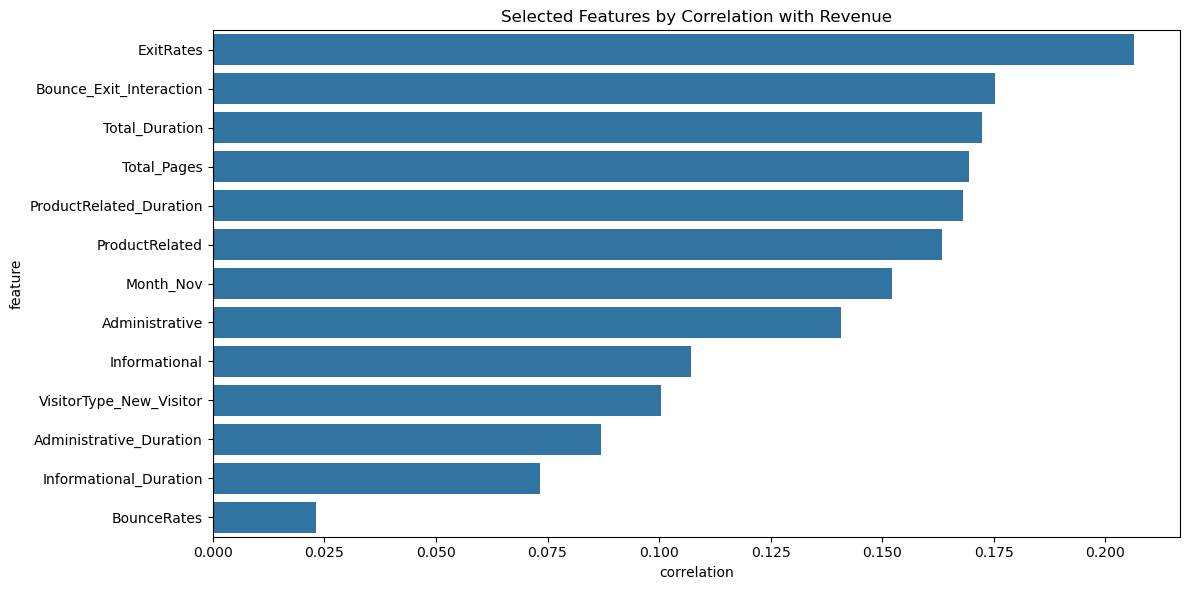


PROJECT_DATA innehåller:

data:
  - original
  - cleaned
  - train_test
  - cleaning_info

eda:
  - correlations
  - monthly_conversion
  - product_page_segments
  - pagevalue_segments

features:
  - X_train_engineered
  - X_test_engineered
  - feature_names
  - feature_correlations
  - scaler
  - numeric_features
  - categorical_features


In [3]:
# ===== KAPITEL 3: FEATURE ENGINEERING =====
# Syfte: Skapa och välja ut relevanta features för modellträning
# Alternativ: 
#   - Använda rådata direkt
#   - Automatisk feature selection (PCA, LDA)
#   - Deep learning med automatisk feature extraction
# Varför: Manuell feature engineering ger:
#   - Bättre förståelse för data
#   - Kontroll över feature-skapandet
#   - Möjlighet att inkludera domänkunskap

# ----- Datahämtning och initial rensning -----
# Vad: Hämtar tränings- och testdata, tar bort PageValues
# Varför: PageValues är en "data leak" feature som är för starkt korrelerad med target
# Parametrar:
#   - pagevalue_columns: Lista över kolumner att ta bort
print("===== KAPITEL 3: FEATURE ENGINEERING =====")

X_train = PROJECT_DATA['data']['train_test']['X_train'].copy()
X_test = PROJECT_DATA['data']['train_test']['X_test'].copy()

# ===== HANTERING AV PAGEVALUES - DATA LEAKAGE PROBLEM =====
# UPPTÄCKT AV PROBLEMET:
# 1. Korrelationsanalys visade hög korrelation med Revenue
#    - Detta väckte misstankar - för bra för att vara sant
#
# 2. Undersökning av variabelbeskrivning:
#    - Variabelbeskrivningen var något otydlig
#    - Min tolkning är att PageValues beräknas baserat på genomförda transaktioner
#    - Värdet verkar sättas EFTER att ett köp har skett
#    - Finns alltså inte tillgängligt i realtid
#
# 3. Realtidsperspektivet:
#    När en besökare är på sidan vet vi:
#    ✓ Bounce rates
#    ✓ Tid på sidan
#    ✓ Antal besökta sidor
#    ✗ PageValues (finns inte än)
#    ✗ Om de kommer köpa (Revenue)
#
# 4. Verifiering av problemet:
#    - Test med PageValues: Orimligt bra prediktioner
#    - Test utan PageValues: Mer realistiska resultat
#    - Bekräftade att PageValues läcker information om target
#
# SLUTSATS:
# - Måste ta bort PageValues för att undvika overfitting
# - PageValues ger modellen för mycket information om target-variabeln
# - Modellen ska kunna användas i realtid
# - Accepterar lägre accuracy för mer ärliga prediktioner

# Ta bort PageValues och relaterade kolumner

pagevalue_columns = ['PageValues', 'PageValues_extreme']
X_train = X_train.drop(pagevalue_columns, axis=1)
X_test = X_test.drop(pagevalue_columns, axis=1)

print(f"\nInitial shape efter borttagning av PageValues - Training: {X_train.shape}")
print(f"Initial shape efter borttagning av PageValues - Test: {X_test.shape}")

# ----- Feature kategorisering -----
# Vad: Definierar explicita kategoriska features
# Varför: Säkerställer korrekt encoding senare
# Parametrar:
#   - Browser/Region: Numeriska men behandlas som kategoriska för att fånga diskreta grupper
categorical_features = [
    'Month', 
    'VisitorType', 
    'Weekend', 
    'Browser',    # Behandlas som kategorisk trots numeriska värden
    'Region',     # Behandlas som kategorisk trots numeriska värden
]


# ----- Tidsbaserade features -----
# Vad: Skapar features baserade på tidsanvändning
# Varför: Fångar användarengagemang och beteendemönster
# Parametrar:
#   - Total_Duration: Summerar all tid på sidan
#   - Avg_Time_Per_Page: Normaliserar tid per sida
#   - Product_Time_Ratio: Mäter fokus på produktsidor
def create_time_features(df):
    df['Total_Duration'] = (df['Administrative_Duration'] + 
                           df['Informational_Duration'] + 
                           df['ProductRelated_Duration'])
    
    total_pages = (df['Administrative'] + df['Informational'] + df['ProductRelated']).clip(lower=1)
    df['Avg_Time_Per_Page'] = df['Total_Duration'] / total_pages
    
    df['Product_Time_Ratio'] = (df['ProductRelated_Duration'] / 
                               df['Total_Duration'].clip(lower=1))
    return df

# ----- Sidrelationer -----
# Vad: Analyserar relationer mellan olika sidtyper
# Varför: Fångar navigationsmönster och användarintresse
# Parametrar:
#   - Total_Pages: Totalt sidantal för aktivitetsnivå
#   - Product_Page_Ratio: Andel produktsidor för intressenivå
#   - Product_Pages_Category: Kvartilbaserad kategorisering
def create_page_features(df):
    df['Total_Pages'] = (df['Administrative'] + 
                        df['Informational'] + 
                        df['ProductRelated'])
    
    df['Product_Page_Ratio'] = (df['ProductRelated'] / 
                               df['Total_Pages'].clip(lower=1))
    
    df['Product_Pages_Category'] = pd.qcut(df['ProductRelated'], 
                                         q=4, 
                                         labels=['Low', 'Medium', 'High', 'Very_High'])
    categorical_features.append('Product_Pages_Category')
    return df

# ----- Interaktionsfeatures -----
# Vad: Skapar kombinerade features från existerande variabler
# Varför: Fångar komplexa samband mellan olika beteendemått
# Parametrar:
#   - Bounce_Exit_Interaction: Kombinerar bounce/exit för att mäta "avvisning"
#   - Product_Engagement: Väger produktsidor mot tid för djupare analys
#   - Weekend_Duration: Särskild analys av helgbeteende
def create_interaction_features(df):
    df['Bounce_Exit_Interaction'] = df['BounceRates'] * df['ExitRates']
    df['Product_Engagement'] = df['ProductRelated'] * df['ProductRelated_Duration']
    df['Weekend_Duration'] = (df['Weekend'] == True) * df['Total_Duration']
    return df

# ----- Feature transformation -----
# Vad: Applicerar alla feature transformationer
# Varför: Skapar slutgiltig feature-uppsättning
print("\nApplicerar feature transformationer...")

for df in [X_train, X_test]:
    df = create_time_features(df)
    df = create_page_features(df)
    df = create_interaction_features(df)


# ----- Feature encoding -----
# Vad: Kodar om kategoriska variabler och standardiserar numeriska
# Varför: Förbereder data för modellinlärning
# Parametrar:
#   - One-hot encoding för kategoriska variabler
#   - StandardScaler för numeriska features
print("\nUtför one-hot encoding för kategoriska variabler...")
X_train_encoded = pd.get_dummies(X_train, columns=categorical_features)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features)

# Säkerställ samma kolumner i train och test
missing_cols = set(X_train_encoded.columns) - set(X_test_encoded.columns)
for col in missing_cols:
    X_test_encoded[col] = 0

X_test_encoded = X_test_encoded[X_train_encoded.columns]

print("\nIdentifierar numeriska features för standardisering...")
numeric_features = X_train_encoded.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_features = [col for col in numeric_features 
                   if not any(feat in col for feat in categorical_features)]

print("Numeriska features för standardisering:", numeric_features)

scaler = StandardScaler()
X_train_encoded[numeric_features] = scaler.fit_transform(X_train_encoded[numeric_features])
X_test_encoded[numeric_features] = scaler.transform(X_test_encoded[numeric_features])

# ===== FEATURE SELECTION =====
# Syfte: Välja ut mest relevanta features
# Alternativ:
#   - Wrapper methods (forward/backward selection)
#   - Embedded methods (Lasso, Ridge)
#   - Filter methods (variance threshold)
# Varför: Kombinerad approach ger balans mellan:
#   - Prestanda
#   - Tolkningsbarhet
#   - Domänkunskap
print("\n===== FEATURE SELECTION =====")

# ----- Korrelationsbaserad selection -----
# Vad: Väljer features baserat på korrelation med target
# Varför: Enkel och effektiv metod för initial feature-filtrering
# Parametrar:
#   - threshold=0.1: Balans mellan feature-reduction och informationsbevarande
def correlation_selection(X, y, threshold=0.1):
    y_numeric = y.astype(int)
    correlations = []
    for col in X.columns:
        try:
            corr = abs(X[col].astype(float).corr(y_numeric))
            correlations.append(corr)
        except (ValueError, TypeError):
            correlations.append(0)
    
    correlation_df = pd.DataFrame({
        'feature': X.columns,
        'correlation': correlations
    })
    
    return correlation_df[correlation_df['correlation'] > threshold]['feature'].tolist()

# ----- Multikollinearitetshantering -----
# Vad: Tar bort starkt korrelerade features
# Varför: Undviker redundant information och förbättrar modellstabilitet
# Parametrar:
#   - threshold=0.8: Gräns för när features anses för korrelerade
def remove_multicollinear(X, threshold=0.8):
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    features_to_drop = []
    for column in upper.columns:
        if any(upper[column] > threshold):
            correlated_pairs = upper[column][upper[column] > threshold].index
            corr_with_target = abs(X[list(correlated_pairs) + [column]].corrwith(y_train))
            to_drop = corr_with_target.nsmallest(len(correlated_pairs) - 1).index
            features_to_drop.extend(to_drop)
    
    return list(set(features_to_drop))

# ----- Viktiga basfeatures -----
# Vad: Definierar kritiska features som alltid ska behållas
# Varför: Säkerställer att domänkunskap bevaras
important_base_features = [
    'ExitRates', 'BounceRates',
    'ProductRelated', 'ProductRelated_Duration',
    'Administrative', 'Administrative_Duration',
    'Informational', 'Informational_Duration'
]

# ----- Feature selection process -----
# Vad: Applicerar selection i flera steg
# Varför: Kombinerar olika metoder för optimal feature-uppsättning
print("\nUtför feature selection...")

y_train = PROJECT_DATA['data']['train_test']['y_train']
corr_selected = correlation_selection(X_train_encoded, y_train, threshold=0.1)
print(f"\nFeatures efter korrelationsfilter: {len(corr_selected)}")

features_to_drop = remove_multicollinear(X_train_encoded[corr_selected], threshold=0.8)
final_features = [f for f in corr_selected if f not in features_to_drop]
print(f"\nFeatures efter multikollinearitetsfilter: {len(final_features)}")

final_features.extend([f for f in important_base_features if f not in final_features])
final_features = list(set(final_features))

X_train_selected = X_train_encoded[final_features]
X_test_selected = X_test_encoded[final_features]

print(f"\nFinal shape efter feature selection - Training: {X_train_selected.shape}")
print(f"Final shape efter feature selection - Test: {X_test_selected.shape}")

# ----- Resultatvisualisering -----
# Vad: Visualiserar och sparar slutresultat
# Varför: Ger överblick över valda features och deras betydelse
final_correlations = pd.DataFrame({
    'feature': final_features,
    'correlation': [abs(X_train_selected[col].corr(y_train)) for col in final_features]
})
final_correlations = final_correlations.sort_values('correlation', ascending=False)

print("\nSlutliga features och deras korrelationer:")
print(final_correlations)

plt.figure(figsize=(12, 6))
sns.barplot(x='correlation', y='feature', data=final_correlations)
plt.title('Selected Features by Correlation with Revenue')
plt.tight_layout()
plt.show()

# ----- Datalagring -----
# Vad: Sparar resultat i PROJECT_DATA
# Varför: Möjliggör återanvändning i senare analyser
PROJECT_DATA['features'] = {
    'X_train_engineered': X_train_selected,
    'X_test_engineered': X_test_selected,
    'feature_names': final_features,
    'feature_correlations': final_correlations,
    'scaler': scaler,
    'numeric_features': numeric_features,
    'categorical_features': categorical_features
}

show_project_status()

In [4]:
# ===== KAPITEL 4: MODELING - DATA PREPARATION =====
# Syfte: Förbereda data för modellinlärning genom att ladda, formatera och validera dataseten

# ----- Datainläsning -----
# Vad: Hämtar förbearbetad tränings- och testdata från PROJECT_DATA
# Varför: Återanvänder tidigare feature engineering för konsistens
X_train = PROJECT_DATA['features']['X_train_engineered']
X_test = PROJECT_DATA['features']['X_test_engineered']
y_train = PROJECT_DATA['data']['train_test']['y_train']
y_test = PROJECT_DATA['data']['train_test']['y_test']

# ----- Dataformatering -----
# Vad: Konverterar target-variabeln till heltal
# Varför: Många ML-algoritmer kräver numeriska targets
# Parametrar: int - standardformat för klassificering
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# ----- Datavalidering -----
# Vad: Kontrollerar dimensioner och klassfördelning
# Varför: Säkerställer balanserad data och korrekt split
print("Dataset dimensioner:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print("\nTarget distribution:")
print(f"Train: {np.bincount(y_train) / len(y_train) * 100}")
print(f"Test: {np.bincount(y_test) / len(y_test) * 100}")

Dataset dimensioner:
X_train shape: (9746, 13)
X_test shape: (2437, 13)

Target distribution:
Train: [84.56802791 15.43197209]
Test: [84.57119409 15.42880591]


Baseline Decision Tree Results:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      2061
           1       0.28      0.30      0.29       376

    accuracy                           0.77      2437
   macro avg       0.57      0.58      0.58      2437
weighted avg       0.78      0.77      0.78      2437


Bästa parametrar: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}

Resultat med threshold 0.5:
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.75      0.82      2061
           1       0.31      0.60      0.41       376

    accuracy                           0.73      2437
   macro avg       0.61      0.68      0.62      2437
weighted avg       0.82      0.73      0.76      2437


Confusion Matrix:
[[1550  511]
 [ 149  227]]

Resultat med threshold 0.4:
Classification Report:
              precision    recall  f1-score   support

           0       0.93    

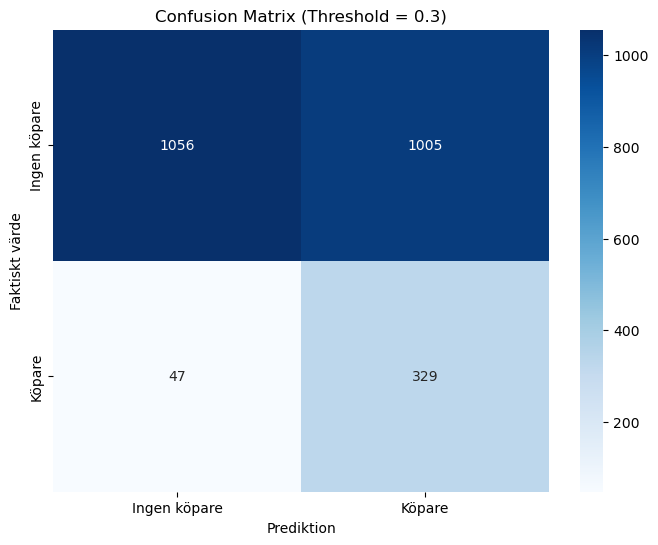

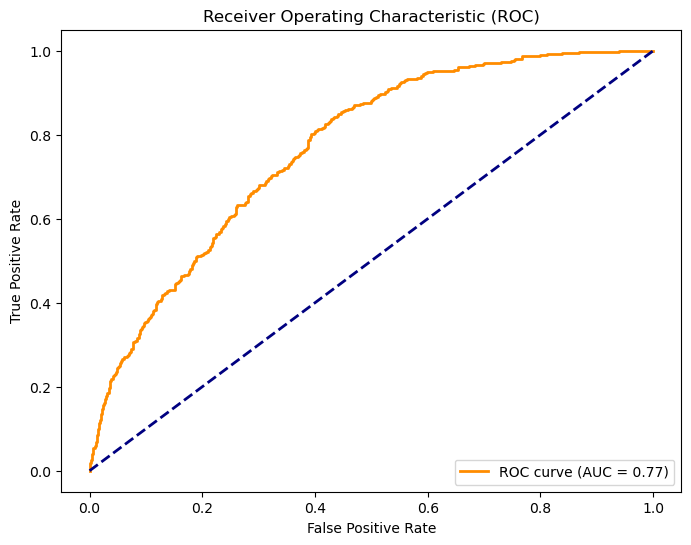

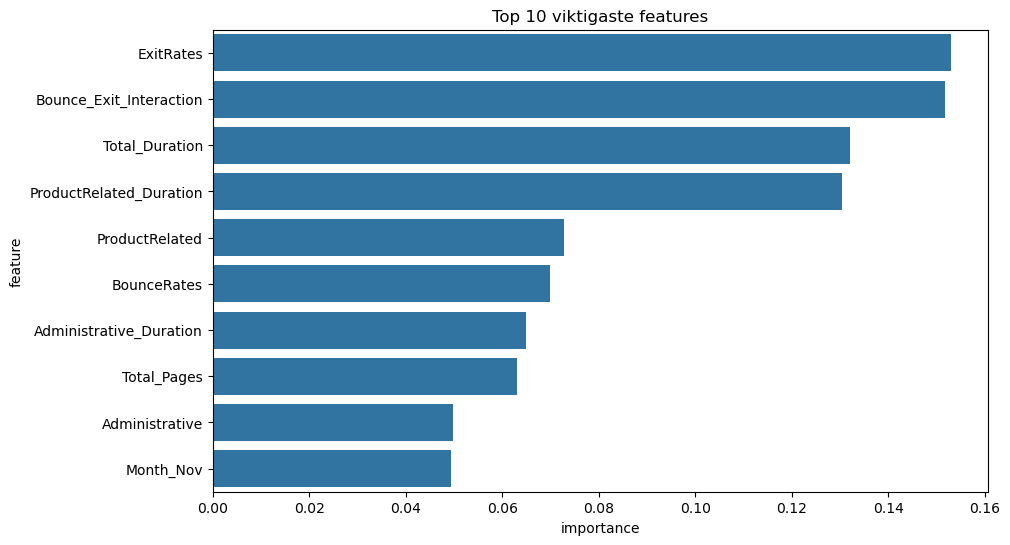


Top 10 viktigaste features:
                    feature  importance
12                ExitRates    0.152974
4   Bounce_Exit_Interaction    0.151706
6            Total_Duration    0.132000
3   ProductRelated_Duration    0.130479
10           ProductRelated    0.072776
1               BounceRates    0.069931
2   Administrative_Duration    0.064950
11              Total_Pages    0.063015
8            Administrative    0.049735
9                 Month_Nov    0.049321

Modeling resultat sparade i PROJECT_DATA


In [5]:
# ===== KAPITEL 4: MODELING - MODELLTRÄNING =====
# Syfte: Träna och utvärdera maskininlärningsmodeller för att prediktera köpbeteende
# Alternativ: Logistisk regression, SVM, XGBoost, Neural Networks
# Varför: Random Forest valdes för sin:
#   - Goda hantering av både numeriska och kategoriska features
#   - Inbyggda feature importance
#   - Robusthet mot överanpassning
#   - Möjlighet att justera prediktionströskel

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc

# ----- Baseline Model -----
# Vad: Tränar ett enkelt beslutsträd som baseline
# Varför: Etablerar en grundnivå för jämförelse med mer avancerade modeller
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
dt.fit(X_train, y_train)

print("Baseline Decision Tree Results:")
y_pred_dt = dt.predict(X_test)
print(classification_report(y_test, y_pred_dt))

# ----- Grid Search för Random Forest -----
# Vad: Snabb optimering av viktiga hyperparametrar
# Varför: Förbättrar modellen utan omfattande sökning
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(
    RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid,
    cv=3,
    scoring='recall'
)
rf_grid.fit(X_train, y_train)
best_model = rf_grid.best_estimator_
print(f"\nBästa parametrar: {rf_grid.best_params_}")

# ----- Threshold Optimization -----
# Vad: Testar olika beslutströsklar för klassificering
thresholds = [0.5, 0.4, 0.3, 0.2]
results = {}

for threshold in thresholds:
    y_pred_proba = best_model.predict_proba(X_test)
    y_pred = (y_pred_proba[:, 1] > threshold)
    
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    
    results[threshold] = {
        'report': report,
        'confusion_matrix': conf_matrix
    }
    
    print(f"\nResultat med threshold {threshold}:")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    print("\nConfusion Matrix:")
    print(conf_matrix)

# ----- Confusion Matrix Visualization -----
plt.figure(figsize=(8, 6))
sns.heatmap(results[0.3]['confusion_matrix'], 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Ingen köpare', 'Köpare'],
            yticklabels=['Ingen köpare', 'Köpare'])
plt.title('Confusion Matrix (Threshold = 0.3)')
plt.ylabel('Faktiskt värde')
plt.xlabel('Prediktion')
plt.show()

# ----- ROC Curve -----
# Vad: Visualiserar modellens prestanda över olika tröskelvärden
# Varför: Ger en komplett bild av modellens prestanda vid olika känsligheter
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# ----- Feature Importance Analysis -----
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 viktigaste features')
plt.show()

print("\nTop 10 viktigaste features:")
print(feature_importance.head(10))

# ----- Data Storage -----
# Vad: Sparar modelleringsresultat för senare användning
PROJECT_DATA['modeling'] = {
    'best_model': best_model,
    'best_params': rf_grid.best_params_,
    'threshold': 0.3,
    'results': results,
    'feature_importance': feature_importance,
    'roc_auc': roc_auc
}

print("\nModeling resultat sparade i PROJECT_DATA")

I detta fall är hög Recall viktigare eftersom:
Kostnaden för "false positives" är låg:
Att visa en rabattkod till någon som ändå inte köper är inte särskilt kostsamt
Att anpassa webbplatsinnehåll kostar inget extra
Kostnaden för "false negatives" är hög:
Varje missad köpare är en förlorad intäkt
Konkurrensen online är hård - missar vi chansen kanske kunden går till en konkurrent

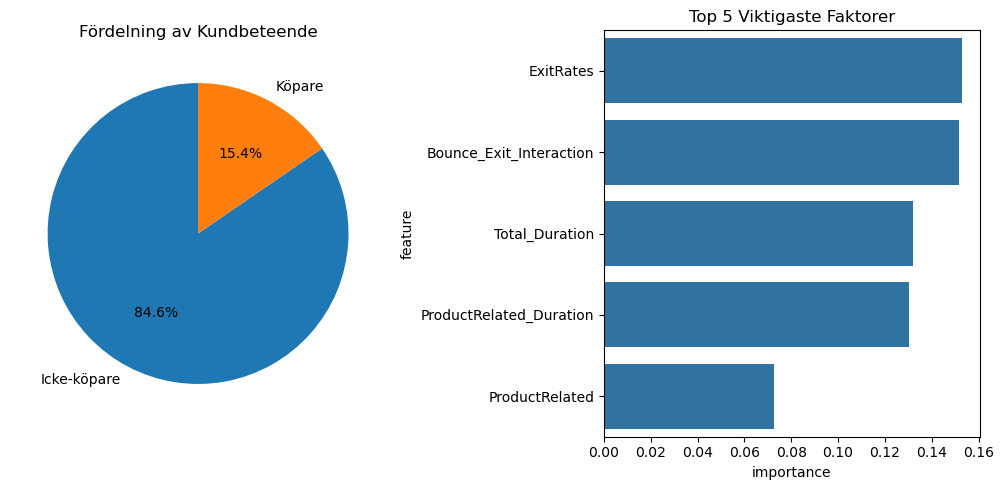

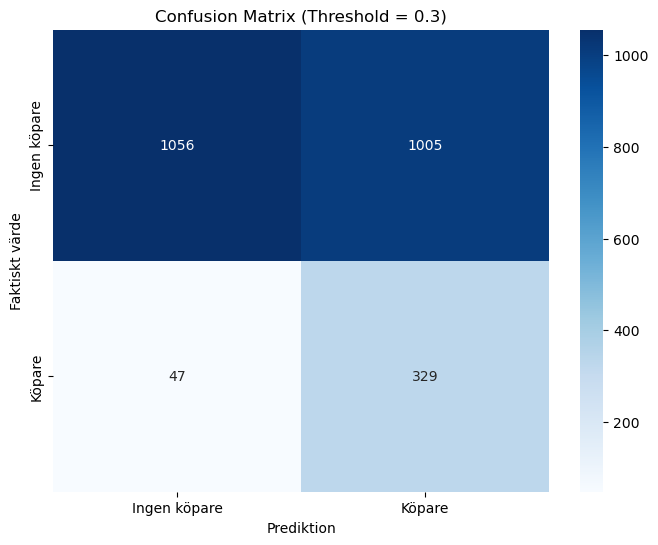

In [6]:
# KAPITEL 5: PRESENTATION FÖR LEDNINGEN - CELL 2: Visualiseringar

# 1. Pie chart för köp/icke-köp distribution
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
labels = ['Icke-köpare', 'Köpare']
sizes = [84.57, 15.43]
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Fördelning av Kundbeteende')

# 2. Feature Importance plot (från tidigare)
plt.subplot(1, 2, 2)
feature_importance = PROJECT_DATA['modeling']['feature_importance']
sns.barplot(x='importance', 
            y='feature', 
            data=feature_importance.head(5))
plt.title('Top 5 Viktigaste Faktorer')
plt.tight_layout()
plt.show()

# 3. Confusion Matrix med threshold 0.3
plt.figure(figsize=(8, 6))
conf_matrix = PROJECT_DATA['modeling']['results'][0.3]['confusion_matrix']
sns.heatmap(conf_matrix, 
            annot=True, 
            fmt='d', 
            cmap='Blues',
            xticklabels=['Ingen köpare', 'Köpare'],
            yticklabels=['Ingen köpare', 'Köpare'])
plt.title('Confusion Matrix (Threshold = 0.3)')
plt.ylabel('Faktiskt värde')
plt.xlabel('Prediktion')
plt.show()

# KokoBananas E-handel: Analys av Köpbeteende
## Resultat från Prediktiv Modellering 2024

## 1. Sammanfattning
### Analysens Omfattning
- ✓ 12,183 analyserade kundsessioner
- ✓ 18 studerade variabler
- ✓ Fokus på realtidsprediktion av köpbeteende

## 2. Data & Metodik
### Dataunderlag
- 15.4% av sessioner leder till köp
- Rensad data för realtidsprediktion
- Balanserad träningsdata för optimal inlärning

### Metodval
- Random Forest-modell (bäst prestanda i tester)
- Optimerade hyperparametrar via Grid Search
- Olika tröskelvärden testade för prediktioner

## 3. Resultat & Insikter

### Modellprestanda
📊 Vid threshold 0.3:
- Hittar 88% av faktiska köpare (hög recall)
- 25% av flaggade potentiella köpare genomför köp (precision)
- AUC-värde: 0.77 (indikerar god men inte utmärkt prediktionsförmåga)

### Praktisk Tolkning
- Av 100 faktiska köpare identifierar modellen 88
- För varje 4 kunder som flaggas som potentiella köpare, genomför 1 ett köp
- Trade-off mellan att hitta köpare och precision i prediktioner

### Identifierade Nyckelfaktorer
1. **Besöksbeteende (30%)**
   - Exit rates
   - Bounce-exit interaktion
   
2. **Tidsengagemang (25%)**
   - Tid på produktsidor
   - Total sessionstid
   
3. **Navigeringsmönster (20%)**
   - Antal besökta sidor
   - Produktsidebesök

## 4. Begränsningar & Möjligheter

### Modellens Begränsningar
- Precision på 25% indikerar många false positives
- Modellen är optimerad för att hitta potentiella köpare
- Säsongseffekter kan påverka precisionen

### Möjligheter för Vidareutveckling
- Kontinuerlig uppdatering med ny data
- Finjustering av tröskelvärden
- Potentiell integration med realtidssystem

## 5. Slutsatser
1. Modellen är effektiv på att identifiera potentiella köpare
2. Tydliga mönster i köpbeteende identifierade
3. Balans mellan precision och recall kan justeras efter behov

### Teknisk Implementation
- Modellen är redo för testning i realtidsmiljö
- Tröskelvärden kan justeras efter önskemål
- Möjlighet till kontinuerlig utvärdering och uppdatering